In [4]:
import matplotlib.pyplot as plt
from graphviz import Source
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [98]:
import warnings
warnings.filterwarnings("ignore")

In [80]:
import pandas as pd
import numpy as np
import catboost
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
import imblearn
import xgboost
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV

In [25]:
transactions = pd.read_csv('hits0712.csv')
features = pd.read_csv('features.csv')
features.index = features['Unnamed: 0']
features = features.drop('Unnamed: 0', axis = 1)

In [92]:
transactions

,Unnamed: 0,event_id,user_id,rec_user_id,date_time,resolution,sub_channel
0,5,0fcea7fec4ff479cac8cf37b4555c817,75301207,49913000,2018-12-07 07:56:49,G,ATMAPI
1,6,c29a4e64d27b435b9b55aa3e62ce54d4,1200695,12797310,2018-12-07 07:14:41,G,MOBILEAPI
2,8,3107b2b1afcb490ab0a31135eb4b386c,45657780,23814017,2018-12-07 14:02:30,G,MOBILEAPI
3,10,d9bc95d991144d53b950d8084fa846bf,21683486,9865131,2018-12-07 10:32:41,G,WEBAPI
4,22,9fc959da4cd144ea8bf5bae2dc041a5e,4531894,VSP15472255,2018-12-07 18:22:52,G,MOBILEAPI
...,...,...,...,...,...,...,...
9011,23682,28ea1a08c79240449922d5756646a353,92237374,69162645,2018-12-07 17:46:35,G,MOBILEAPI
9012,23683,65a5b1dd74564e99b3b3c39b9ee460f7,3316389,89796796,2018-12-07 18:42:47,G,WEBAPI
9013,23684,df808870913643c7ba24e990e6bbea39,24338601,58490342,2018-12-07 13:55:59,G,MOBILEAPI
9014,23685,de1b30f52c264e95816e0cc163b2c116,2000352,37033043,2018-12-07 17:55:32,G,ATMAPI


In [93]:
feature_columns = ['mu1','std1','mu2','std2']
for num in ['1','2']:
    for intr in ['own interval', 'genue interval', 'fraud interval', 'rec fraud interval']:
        for alpha in ['0.9', '0.8', '0.7', '0.6']:
            for hits in ['5', '10']:
                feature_columns.append(num+' in '+intr+alpha+' '+hits)
for num in ['1','2']:
    for hmm in ['genue hmm likehood time', 'fraud hmm likehood time', 'rec fraud hmm likehood time']:
        feature_columns.append(num+hmm)
for num in ['1','2']:
    for hmm in ['genue hmm likehood amount', 'fraud hmm likehood amount', 'rec fraud hmm likehood amount']:
        feature_columns.append(num+hmm)
feature_columns.append('ATMAPI')
feature_columns.append('MOBILEAPI')
feature_columns.append('WEBAPI')

In [26]:
features.head()

,0,1,2,3,0.1,1.1,2.1,3.1,4,5,...,2.2,3.2,4.1,5.1,6.1,7.1,8.1,9.1,10.1,11.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
8896,3.745319,0.872427,3.209817,0.674154,5,9,5,9,5,9,...,-66.229156,-85.390402,-89.460849,-89.984051,-28.221735,-26.389031,-37.228117,-50.888986,-52.546837,-61.638430
3728,2.947270,1.531647,2.725168,1.156245,5,10,4,9,2,7,...,-87.665243,-1397.036588,-3089.878996,-2021.871496,-47.382954,-49.770557,-57.023205,-1914.051188,-3100.104397,-2226.181453
3117,3.127159,1.107837,3.822262,0.979826,5,10,5,8,5,7,...,-133.806332,-86.386229,-88.702509,-90.151951,-105.053513,-124.860443,-133.410846,-44.889651,-48.216110,-58.855747
5678,3.187871,1.362122,2.419445,1.331188,4,8,4,8,4,7,...,-81.027183,-110.945947,-127.669541,-116.437233,-65.802706,-76.607795,-97.985126,-88.593321,-129.104506,-104.518719
1582,1.491757,0.428428,2.768607,1.200823,5,6,5,6,5,6,...,-10.901590,-66.326215,-77.583228,-70.301995,-5.110407,-8.098710,-7.293094,-43.535486,-51.529935,-58.292169


In [27]:
enc = OneHotEncoder(sparse=False)
sub_chan = enc.fit_transform(transactions.iloc[features.index].sub_channel.values.reshape((-1,1)))

In [28]:
sub_chan = pd.DataFrame(sub_chan)
sub_chan.index = features.index
features = pd.concat([features, sub_chan], axis =1)

In [30]:
features.columns = list(range(83))
features.isna().sum()[features.isna().sum()>0]

1    4
3    4
dtype: int64

In [32]:
features[[1,3]][transactions.resolution!='G'].isna().sum()

/Users/valerka_bvv/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


1    0
3    0
dtype: int64

In [33]:
features = features.fillna(0)

In [50]:
target = transactions.resolution.apply(lambda x: 1 if x != 'G' else 0).iloc[features.index]

### Уменьшим количество элементов класса 0, увеличим класс 1, оставив в итоге 20% фрода

In [52]:
X_und, y_und = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.01).fit_resample(features, target)
X_os, y_os = imblearn.over_sampling.ADASYN(sampling_strategy=0.2).fit_resample(X_und, y_und)

In [53]:
vis_mod = TSNE().fit_transform(X = features)

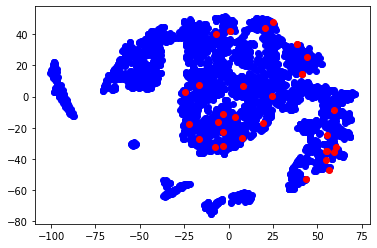

In [54]:
plt.scatter(vis_mod[target==0][:,0], vis_mod[target==0][:,1], c='b')
plt.scatter(vis_mod[target==1][:,0], vis_mod[target==1][:,1], c='r')
plt.show()

### Теперь обучаем

In [55]:
tr = tree.ExtraTreeClassifier().fit(features,target)

In [61]:
from IPython.display import SVG

In [63]:
import graphviz

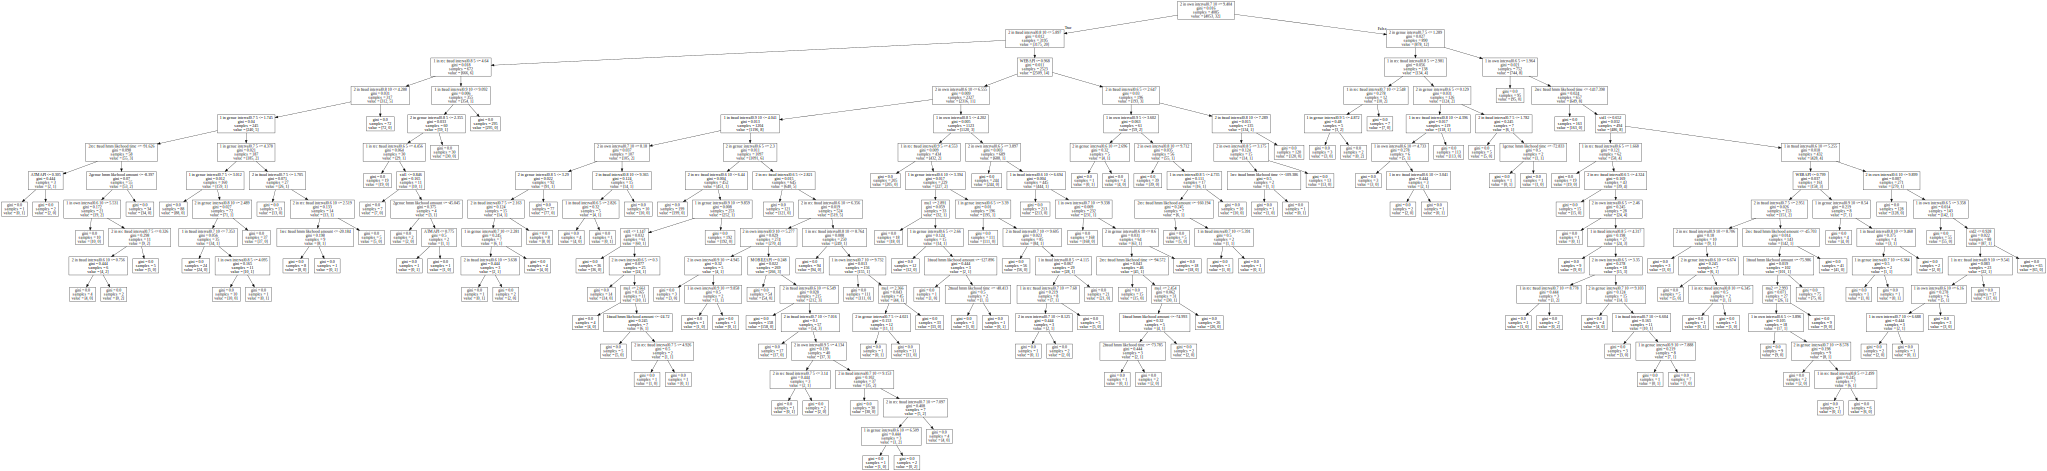

In [94]:
graph = Source( tree.export_graphviz(tr, out_file=None, feature_names=feature_columns))
SVG(graph.pipe(format='svg'))

In [99]:
print('crossvalidation with recall on catboost is',
      cross_val_score(catboost.CatBoostClassifier(verbose=0),X_os,y_os, scoring = metrics.make_scorer(metrics.recall_score)))
print('crossvalidation with precision on catboost is',
      cross_val_score(catboost.CatBoostClassifier(verbose=0),X_os,y_os, scoring = metrics.make_scorer(metrics.precision_score)))

crossvalidation with recall on catboost is [0.82464455 0.95734597 0.96666667]
crossvalidation with precision on catboost is [1. 1. 1.]


In [100]:
cat_model = catboost.CatBoostClassifier().fit(X_os,y_os)

Learning rate set to 0.024504
0:	learn: 0.6613738	total: 11.8ms	remaining: 11.8s
1:	learn: 0.6358162	total: 21.1ms	remaining: 10.5s
2:	learn: 0.6081507	total: 31.4ms	remaining: 10.4s
3:	learn: 0.5836911	total: 40.7ms	remaining: 10.1s
4:	learn: 0.5611731	total: 50.1ms	remaining: 9.97s
5:	learn: 0.5384559	total: 59.7ms	remaining: 9.89s
6:	learn: 0.5176713	total: 69ms	remaining: 9.79s
7:	learn: 0.4962479	total: 79ms	remaining: 9.8s
8:	learn: 0.4752868	total: 88ms	remaining: 9.69s
9:	learn: 0.4570754	total: 97.3ms	remaining: 9.64s
10:	learn: 0.4400490	total: 107ms	remaining: 9.58s
11:	learn: 0.4282769	total: 116ms	remaining: 9.55s
12:	learn: 0.4148267	total: 128ms	remaining: 9.74s
13:	learn: 0.3998762	total: 138ms	remaining: 9.69s
14:	learn: 0.3885663	total: 147ms	remaining: 9.65s
15:	learn: 0.3768288	total: 157ms	remaining: 9.63s
16:	learn: 0.3670850	total: 166ms	remaining: 9.61s
17:	learn: 0.3571159	total: 176ms	remaining: 9.58s
18:	learn: 0.3472700	total: 186ms	remaining: 9.61s
19:	lear

166:	learn: 0.0411197	total: 1.64s	remaining: 8.16s
167:	learn: 0.0406875	total: 1.65s	remaining: 8.17s
168:	learn: 0.0404589	total: 1.66s	remaining: 8.15s
169:	learn: 0.0402047	total: 1.67s	remaining: 8.13s
170:	learn: 0.0398054	total: 1.68s	remaining: 8.12s
171:	learn: 0.0395690	total: 1.68s	remaining: 8.11s
172:	learn: 0.0393424	total: 1.69s	remaining: 8.09s
173:	learn: 0.0390241	total: 1.7s	remaining: 8.07s
174:	learn: 0.0386483	total: 1.71s	remaining: 8.06s
175:	learn: 0.0383797	total: 1.72s	remaining: 8.04s
176:	learn: 0.0380147	total: 1.73s	remaining: 8.03s
177:	learn: 0.0375844	total: 1.74s	remaining: 8.01s
178:	learn: 0.0371971	total: 1.74s	remaining: 8s
179:	learn: 0.0368913	total: 1.75s	remaining: 7.98s
180:	learn: 0.0366084	total: 1.76s	remaining: 7.97s
181:	learn: 0.0362924	total: 1.77s	remaining: 7.95s
182:	learn: 0.0359762	total: 1.78s	remaining: 7.94s
183:	learn: 0.0357119	total: 1.79s	remaining: 7.92s
184:	learn: 0.0354192	total: 1.79s	remaining: 7.91s
185:	learn: 0.03

340:	learn: 0.0147584	total: 3.27s	remaining: 6.32s
341:	learn: 0.0147122	total: 3.28s	remaining: 6.31s
342:	learn: 0.0146350	total: 3.29s	remaining: 6.3s
343:	learn: 0.0145528	total: 3.29s	remaining: 6.29s
344:	learn: 0.0144500	total: 3.3s	remaining: 6.27s
345:	learn: 0.0144118	total: 3.31s	remaining: 6.26s
346:	learn: 0.0143757	total: 3.32s	remaining: 6.25s
347:	learn: 0.0143078	total: 3.33s	remaining: 6.24s
348:	learn: 0.0142371	total: 3.34s	remaining: 6.23s
349:	learn: 0.0142262	total: 3.35s	remaining: 6.22s
350:	learn: 0.0141165	total: 3.36s	remaining: 6.21s
351:	learn: 0.0140613	total: 3.37s	remaining: 6.2s
352:	learn: 0.0140087	total: 3.37s	remaining: 6.18s
353:	learn: 0.0139320	total: 3.38s	remaining: 6.17s
354:	learn: 0.0139087	total: 3.39s	remaining: 6.16s
355:	learn: 0.0138823	total: 3.4s	remaining: 6.15s
356:	learn: 0.0138389	total: 3.41s	remaining: 6.14s
357:	learn: 0.0138174	total: 3.42s	remaining: 6.13s
358:	learn: 0.0137313	total: 3.42s	remaining: 6.12s
359:	learn: 0.01

521:	learn: 0.0080036	total: 4.87s	remaining: 4.46s
522:	learn: 0.0079855	total: 4.89s	remaining: 4.46s
523:	learn: 0.0079649	total: 4.91s	remaining: 4.46s
524:	learn: 0.0079379	total: 4.92s	remaining: 4.45s
525:	learn: 0.0079045	total: 4.92s	remaining: 4.44s
526:	learn: 0.0078815	total: 4.93s	remaining: 4.43s
527:	learn: 0.0078384	total: 4.94s	remaining: 4.42s
528:	learn: 0.0078062	total: 4.95s	remaining: 4.41s
529:	learn: 0.0077591	total: 4.96s	remaining: 4.39s
530:	learn: 0.0077457	total: 4.96s	remaining: 4.38s
531:	learn: 0.0077322	total: 4.97s	remaining: 4.38s
532:	learn: 0.0077296	total: 4.98s	remaining: 4.37s
533:	learn: 0.0076934	total: 4.99s	remaining: 4.36s
534:	learn: 0.0076489	total: 5s	remaining: 4.35s
535:	learn: 0.0076436	total: 5.01s	remaining: 4.34s
536:	learn: 0.0076074	total: 5.02s	remaining: 4.33s
537:	learn: 0.0075896	total: 5.03s	remaining: 4.32s
538:	learn: 0.0075643	total: 5.03s	remaining: 4.3s
539:	learn: 0.0075494	total: 5.04s	remaining: 4.3s
540:	learn: 0.007

701:	learn: 0.0052574	total: 6.7s	remaining: 2.84s
702:	learn: 0.0052562	total: 6.71s	remaining: 2.83s
703:	learn: 0.0052459	total: 6.72s	remaining: 2.82s
704:	learn: 0.0052434	total: 6.72s	remaining: 2.81s
705:	learn: 0.0052292	total: 6.73s	remaining: 2.8s
706:	learn: 0.0052272	total: 6.74s	remaining: 2.79s
707:	learn: 0.0052090	total: 6.75s	remaining: 2.78s
708:	learn: 0.0052068	total: 6.76s	remaining: 2.77s
709:	learn: 0.0052004	total: 6.77s	remaining: 2.76s
710:	learn: 0.0051823	total: 6.78s	remaining: 2.75s
711:	learn: 0.0051592	total: 6.78s	remaining: 2.74s
712:	learn: 0.0051467	total: 6.79s	remaining: 2.73s
713:	learn: 0.0051251	total: 6.8s	remaining: 2.72s
714:	learn: 0.0051211	total: 6.81s	remaining: 2.71s
715:	learn: 0.0051082	total: 6.82s	remaining: 2.7s
716:	learn: 0.0050900	total: 6.83s	remaining: 2.69s
717:	learn: 0.0050779	total: 6.84s	remaining: 2.69s
718:	learn: 0.0050727	total: 6.85s	remaining: 2.67s
719:	learn: 0.0050699	total: 6.86s	remaining: 2.67s
720:	learn: 0.00

871:	learn: 0.0039707	total: 8.31s	remaining: 1.22s
872:	learn: 0.0039652	total: 8.32s	remaining: 1.21s
873:	learn: 0.0039593	total: 8.33s	remaining: 1.2s
874:	learn: 0.0039580	total: 8.34s	remaining: 1.19s
875:	learn: 0.0039546	total: 8.34s	remaining: 1.18s
876:	learn: 0.0039442	total: 8.35s	remaining: 1.17s
877:	learn: 0.0039314	total: 8.36s	remaining: 1.16s
878:	learn: 0.0039192	total: 8.37s	remaining: 1.15s
879:	learn: 0.0039160	total: 8.38s	remaining: 1.14s
880:	learn: 0.0039135	total: 8.39s	remaining: 1.13s
881:	learn: 0.0039108	total: 8.39s	remaining: 1.12s
882:	learn: 0.0038949	total: 8.4s	remaining: 1.11s
883:	learn: 0.0038894	total: 8.41s	remaining: 1.1s
884:	learn: 0.0038836	total: 8.42s	remaining: 1.09s
885:	learn: 0.0038759	total: 8.43s	remaining: 1.08s
886:	learn: 0.0038657	total: 8.44s	remaining: 1.07s
887:	learn: 0.0038597	total: 8.45s	remaining: 1.06s
888:	learn: 0.0038571	total: 8.45s	remaining: 1.05s
889:	learn: 0.0038351	total: 8.46s	remaining: 1.04s
890:	learn: 0.0

In [104]:
pr, rc, th = metrics.precision_recall_curve(target, cat_model.predict_proba(features)[:,1])

In [105]:
pr

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [106]:
rc

array([1.     , 0.96875, 0.9375 , 0.90625, 0.875  , 0.84375, 0.8125 ,
       0.78125, 0.75   , 0.71875, 0.6875 , 0.65625, 0.625  , 0.59375,
       0.5625 , 0.53125, 0.5    , 0.46875, 0.4375 , 0.40625, 0.375  ,
       0.34375, 0.3125 , 0.28125, 0.25   , 0.21875, 0.1875 , 0.15625,
       0.09375, 0.0625 , 0.     ])

In [107]:
th

array([0.81248095, 0.84094815, 0.85618447, 0.8633278 , 0.87417819,
       0.87545607, 0.87814947, 0.89045009, 0.89132463, 0.90012331,
       0.90376375, 0.9074195 , 0.90853433, 0.90879213, 0.91582309,
       0.91817869, 0.91904293, 0.9290581 , 0.93420839, 0.94943412,
       0.94992747, 0.951909  , 0.95410803, 0.95929078, 0.96133983,
       0.96149716, 0.96454104, 0.97605088, 0.98500975, 0.99152357])